# Imports

In [2]:
# Install the required packages
%pip install torch torchvision torchmetrics tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torchmetrics

Note: you may need to restart the kernel to use updated packages.


# Getting the Dataset and Inspecting it

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:59<00:00, 94.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
import os

# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset:", dataset_files)


Files in the dataset: ['HAM10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv']


# Viewing the Images

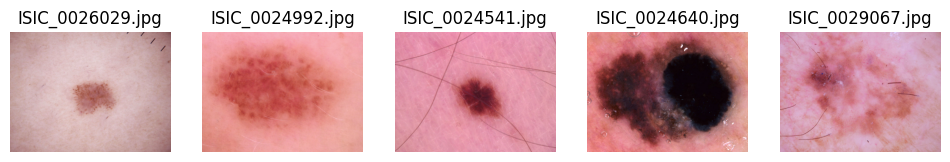

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display a few images
image_folder = os.path.join(path, "HAM10000_images_part_1")  # Adjust if necessary
sample_images = os.listdir(image_folder)[:5]  # Show first 5 images

plt.figure(figsize=(12, 8))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.show()

# Inspecting the size of the images

In [ ]:
import cv2

In [ ]:
# Define the path to the image folder (adjust if needed based on output of previous step)
image_folder = os.path.join(path, "HAM10000_images_part_1")

# List the first few images in this folder
sample_images = os.listdir(image_folder)
print("Sample images:", sample_images[:5])

image_path = os.path.join(image_folder, sample_images[0])
# Load image and check dimensions
img = cv2.imread(image_path)
height, width, channels = img.shape
print("Image size:", (width, height))

Sample images: ['ISIC_0026029.jpg', 'ISIC_0024992.jpg', 'ISIC_0024541.jpg', 'ISIC_0024640.jpg', 'ISIC_0029067.jpg']
Image size: (600, 450)
